In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pickle
import math
from sklearn.linear_model import LogisticRegression

import imp
imp.load_source('DataFns', "/glade/u/home/kwheelan/scripts/DataFns.py")
from DataFns import *

imp.load_source('StatFns', "/glade/u/home/kwheelan/scripts/StatFns.py")
from StatFns import *

/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190326/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [15]:
OLS = xr.open_dataset('/glade/work/kwheelan/datasets/FinalModelsPreds/OLS_log_odd_yrs.nc')
Unet = xr.open_dataset('/glade/work/kwheelan/datasets/predictions/unet/unet_odd_preds17.nc')
RF = xr.open_dataset('/glade/work/kwheelan/datasets/FinalModelsPreds/Cellwise_RF_allOddYrs.nc')

In [16]:
master = RF
master['Unet'] = Unet.preds
master['RF'] = RF.final_prcp_prediction
master['OLS']=OLS.final_pred

In [17]:
master_df = master.to_dataframe().reset_index().dropna()

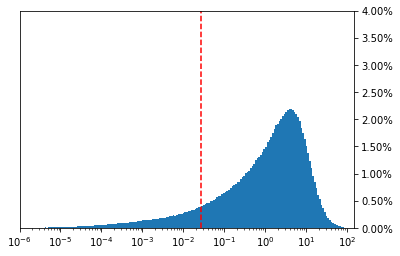

In [18]:
#Plotting the distribution on a log scale

var='RCM' #the variable to plot (ie. RCM)
prednon0=master_df[master_df[var] > 0.00] #filtering to get only non-zero precip values

length = prednon0.shape[0] #number of pts

pmean = round(prednon0[var].mean(),3) #mean
pstd = round(prednon0[var].std(),3) #standard deviation
x=prednon0[var] #extract data for given column name
ax = plt.subplot()
ax.set_xscale("log", nonposx='clip')
logbins = np.geomspace(0.000001,150, 200) #args are x-min, x-max, number of bins
plt.axvline(x=0.027, color='red', linestyle='--') #drawing a line at the cut-off for obs precip (it's 0.027 so it doens't cut off values at 0.03)
plt.hist(x,bins=logbins, weights=np.ones(length) / length) #plot percentages
#plt.title(var+' Non-Zero Precipitation Distribution',fontsize=18) #title
plt.xlim(xmin=0.000001, xmax = 150)
plt.ylim(ymin=0, ymax = 0.04)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals]) #add % to axis labels
ax.yaxis.tick_right()
#plt.text(5,805000, "Mean: " + str(pmean) + "\nStd: " + str(pstd)) #show mean and std
plt.show()

In [19]:
#Finding domain-wide precip averages for each odd year

mastercp = master.copy()
mastercp['time']=pd.DatetimeIndex(master['time'].values).year

yrAvgs = pd.DataFrame()
for col in ['obs', 'RCM', 'OLS', 'RF', 'Unet']:
    yrAvgs[col] = [float(mastercp.sel(time = year).mean(dim=['latitude','longitude']).mean()[col].values) for year in range(1981, 2010, 2)]
yrAvgs['year'] = [yr for yr in range(1981, 2010, 2)]

In [20]:
#Bias correcting each model for comparison

mastercp['Unet-scaled'] = mastercp.Unet * mastercp.obs.mean()/mastercp.Unet.mean()
mastercp['OLS-scaled'] = mastercp.OLS * mastercp.obs.mean()/mastercp.OLS.mean()
mastercp['RF-scaled'] = mastercp.RF * mastercp.obs.mean()/mastercp.RF.mean()
mastercp['Observed'] = mastercp.obs
mastercp['U-Net'] = mastercp.Unet

Text(0.5,0,'year')

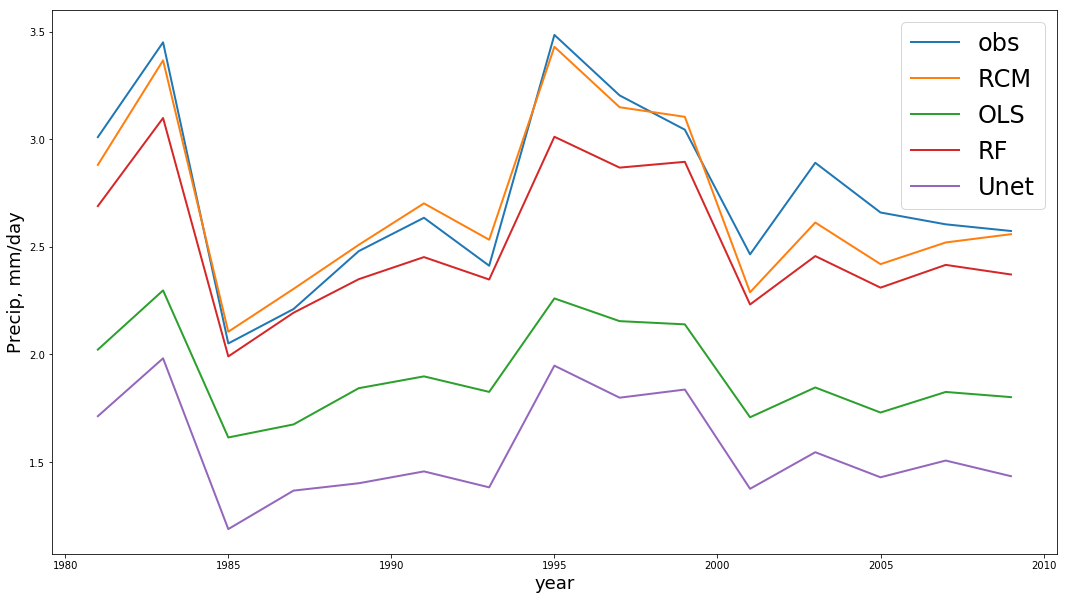

In [21]:
#Plotting interannual variation (domain-wide average precip for each odd year) for each model


from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 10))

#Change the list of columns to plot to see other variables 
for col in ['obs', 'RCM', 'OLS', 'RF', 'Unet']:
    plt.plot(yrAvgs.year, yrAvgs[col], label = col, linewidth=(col=='Observed')*3+2, linestyle=['solid','--'][col=='Observed'])
plt.legend(loc='upper right', prop={'size': 24})
plt.ylabel('Precip, mm/day', fontsize=18)
plt.xlabel('year',  fontsize=18)
#plt.ylim(ymin=0, ymax=4)

(0, 4)

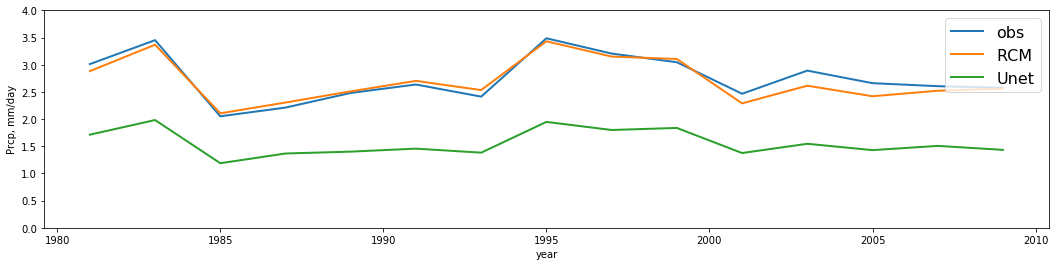

In [25]:
#Making a long, short plot

from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 4))

for col in ['obs', 'RCM', 'Unet']:
    plt.plot(yrAvgs.year, yrAvgs[col], label = col, linewidth=(col=='Observed')*1+2, linestyle=['solid','--'][col=='Observed'])
plt.legend(loc='upper right', prop={'size': 16})
plt.ylabel('Prcp, mm/day')
plt.xlabel('year')
plt.ylim(ymin=0, ymax=4)

In [27]:
#Loading elevation data for possible plotting later

RCM_elevation = xr.open_mfdataset('/glade/collections/cdg/work/cordex/esgf/wrf/era-int/nam-44i/eval/fx/orog*')
elevation = xr.open_dataset('/glade/work/kwheelan/datasets/PNW_w_elevation.nc')
elevation = maskWater(elevation.to_dataframe(),'elevation')
elevation['elevation'][elevation['elevation'].isna()]=-100000
elevation = elevation.to_xarray()

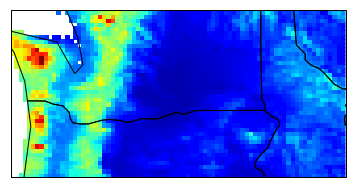

In [29]:
#Ethan's code to add state borders to plots

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.RIVERS)
#ax.gridlines(crs=proj, linewidth=0.25, color='black', alpha=1., linestyle='--')
ax.set_extent([-124.5, -114.5, 44, 49])

#Change this line to plot something else (master.obs plots observed values)
(master.obs).mean(dim='time').plot(cmap='jet', vmin=0, vmax=12, add_colorbar=False)